# Bigram

- a `bigram` is essentially a two-word unit that helps us understand how words co-occur and potentially reveal relationships between them.

- Examples of Bigrams:
  - "I love"
  - "machine learning"

## Bigram Character Model

- In Natural Language Processing (NLP), a `bigram character model` focuses on analyzing sequences of `two consecutive characters`, instead of words, to understand and predict the next character in a sequence.

In [1]:
%load_ext watermark
%watermark -v -p numpy,pandas,polars,torch,lightning --conda

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

numpy    : 1.26.4
pandas   : 2.2.1
polars   : 0.20.18
torch    : 2.2.2
lightning: 2.2.1

conda environment: torch_p11



In [2]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt


# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

warnings.filterwarnings("ignore")


# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [3]:
## Load text data
fp: str = "../../../data/names.txt"

with open(fp, "r") as f:
    # Read all the lines as a list
    names: list[str] = f.read().splitlines()

names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [4]:
## Data summary
total: int = len(names)
min_name_len: int = min(len(name) for name in names)
max_name_len: int = max(len(name) for name in names)

console.print(
    (
        f"Total number of names: {total:,} "
        f"\nmin name length: {min_name_len} \nmax name length: {max_name_len}"
    )
)

Total number of names: 32,033 
min name length: 2 
max name length: 15

In [5]:
SPECIAL_TOKEN: str = "<S>"

# Read 2 words at a time
for w in names[:1]:
    # Add special character(s) between words
    word: list[str] = [SPECIAL_TOKEN] + list(w) + [SPECIAL_TOKEN]
    for ch1, ch2 in zip(word, word[1:]):
        print(f"{ch1:3} {ch2:3}")

<S> e  
e   m  
m   m  
m   a  
a   <S>


In [6]:
# Create a count of the bigram characters
SPECIAL_TOKEN: str = "<S>"
SMOOTHING: int = 1
bigram: dict[str, int] = {}

# Read 2 words at a time
for w in names:
    # Add special character(s) between words
    word: list[str] = [SPECIAL_TOKEN] + list(w) + [SPECIAL_TOKEN]
    for ch1, ch2 in zip(word, word[1:]):
        bigram[(ch1, ch2)] = bigram.get((ch1, ch2), SMOOTHING) + 1

# bigram

In [7]:
# Top 10 bigrams
sorted(bigram.items(), key=lambda x: x[1], reverse=True)[:10]

[(('n', '<S>'), 6764),
 (('a', '<S>'), 6641),
 (('a', 'n'), 5439),
 (('<S>', 'a'), 4411),
 (('e', '<S>'), 3984),
 (('a', 'r'), 3265),
 (('e', 'l'), 3249),
 (('r', 'i'), 3034),
 (('n', 'a'), 2978),
 (('<S>', 'k'), 2964)]

### Store the bigrams in an array/tensor


In [8]:
# Number of unique characters
charaters: list[str] = sorted(set([x for name in names for x in name]))
charaters.insert(0, SPECIAL_TOKEN)

print(f"Number of unique characters: {len(charaters)}")
charaters

Number of unique characters: 27


['<S>',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [9]:
import torch
from torch import Tensor


num_chars: int = len(charaters)
# Use int sine it'll be storing counts.
bigram_tensor: Tensor = torch.ones(size=(num_chars, num_chars), dtype=torch.int32)

bigram_tensor[:5]

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]], dtype=torch.int32)

In [10]:
# Convert text to numbers.
text_to_num: dict[str, int] = {text: idx for idx, text in enumerate(charaters)}

# Convert numbers to text
num_to_text: dict[int, str] = {idx: text for text, idx in text_to_num.items()}


console.print(text_to_num, num_to_text)

{
    '<S>': 0,
    'a': 1,
    'b': 2,
    'c': 3,
    'd': 4,
    'e': 5,
    'f': 6,
    'g': 7,
    'h': 8,
    'i': 9,
    'j': 10,
    'k': 11,
    'l': 12,
    'm': 13,
    'n': 14,
    'o': 15,
    'p': 16,
    'q': 17,
    'r': 18,
    's': 19,
    't': 20,
    'u': 21,
    'v': 22,
    'w': 23,
    'x': 24,
    'y': 25,
    'z': 26
}
{
    0: '<S>',
    1: 'a',
    2: 'b',
    3: 'c',
    4: 'd',
    5: 'e',
    6: 'f',
    7: 'g',
    8: 'h',
    9: 'i',
    10: 'j',
    11: 'k',
    12: 'l',
    13: 'm',
    14: 'n',
    15: 'o',
    16: 'p',
    17: 'q',
    18: 'r',
    19: 's',
    20: 't',
    21: 'u',
    22: 'v',
    23: 'w',
    24: 'x',
    25: 'y',
    26: 'z'
}

In [11]:
# Read 2 words at a time
for w in names:
    # Add special character(s) between words
    word: list[str] = [SPECIAL_TOKEN] + list(w) + [SPECIAL_TOKEN]
    for ch1, ch2 in zip(word, word[1:]):
        # Convert to index
        idx1, idx2 = text_to_num.get(ch1), text_to_num.get(ch2)
        bigram_tensor[idx1, idx2] += 1

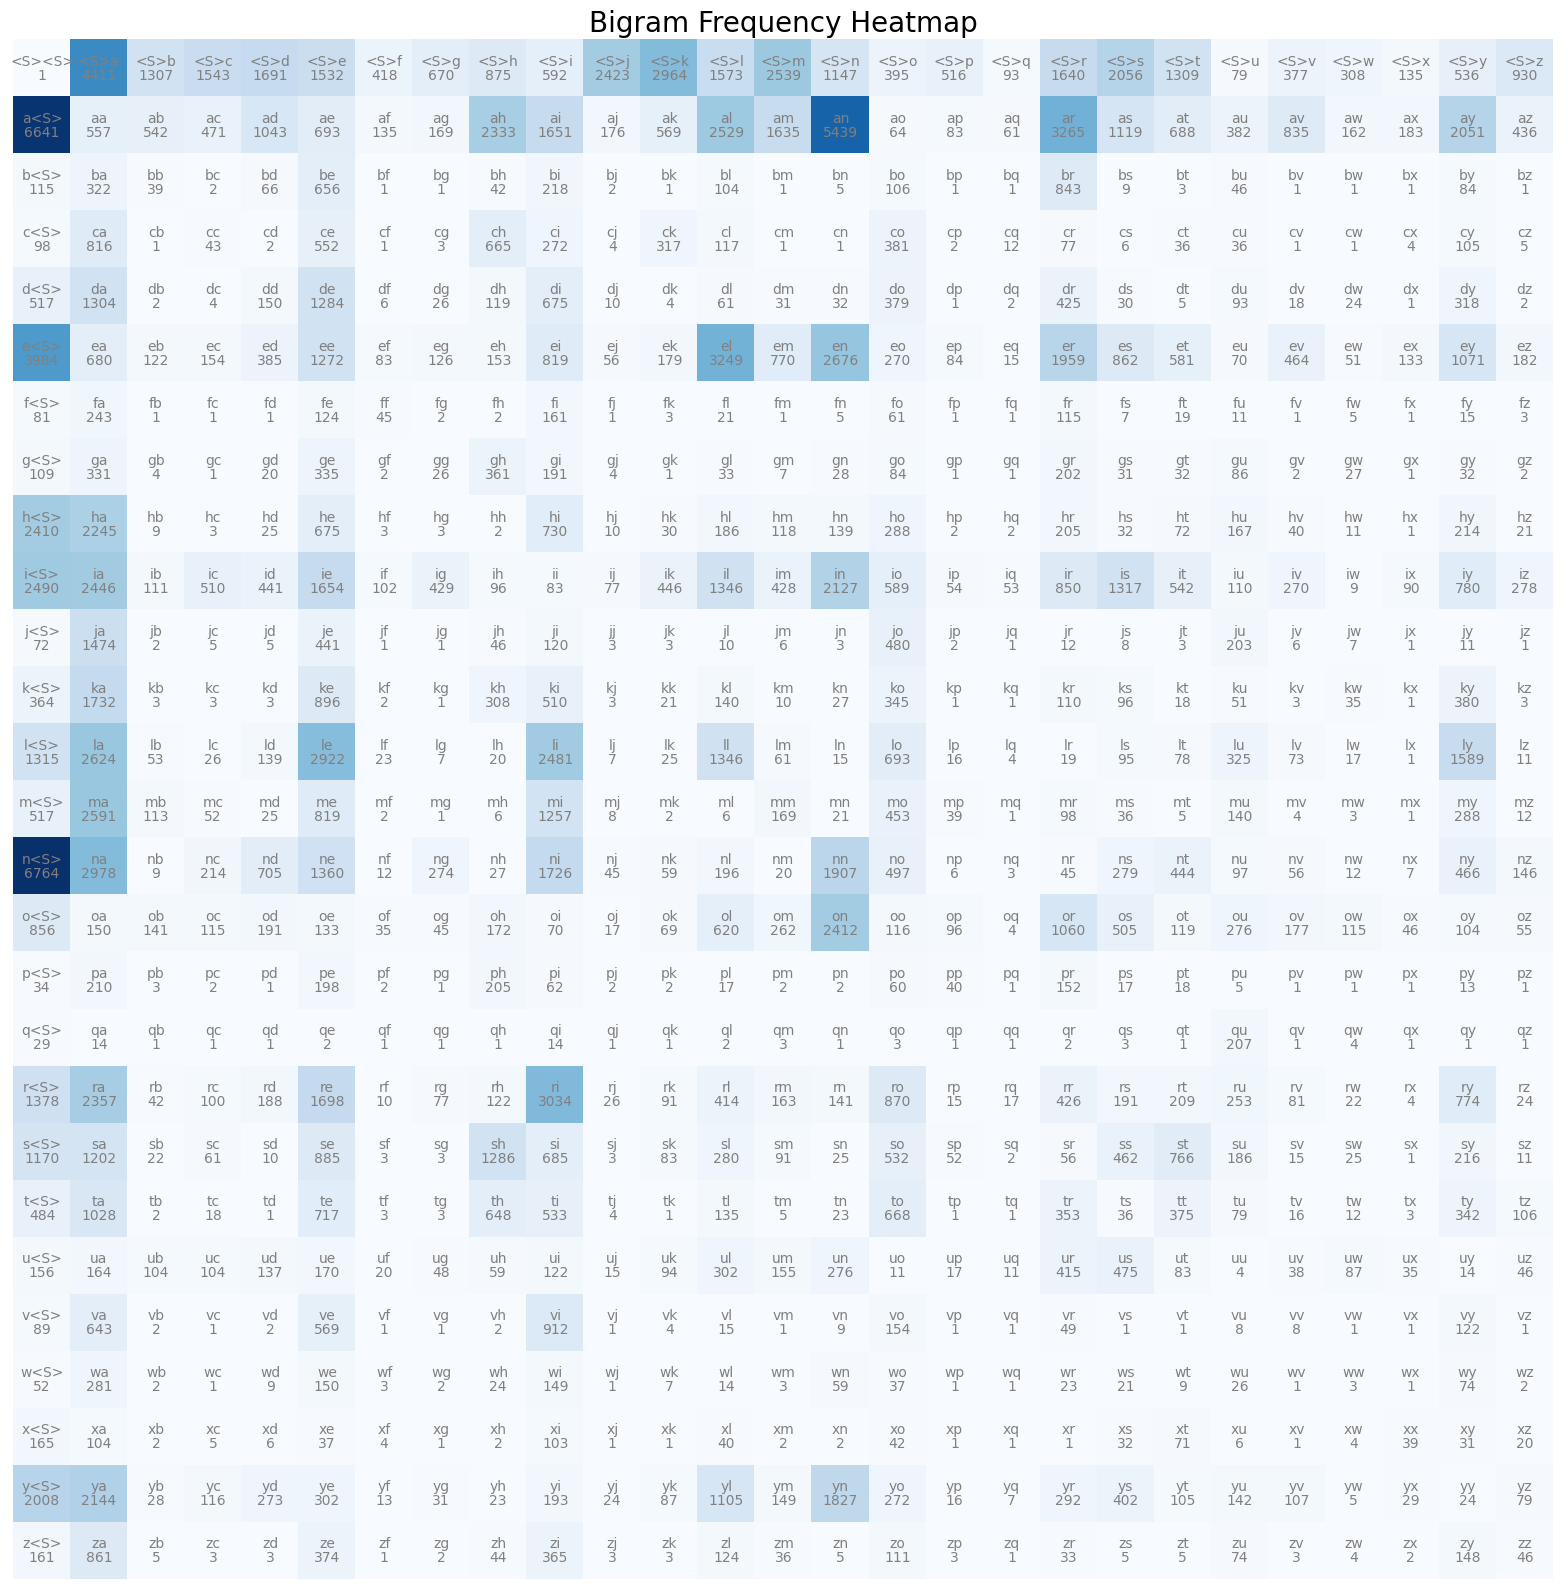

In [12]:
# plt.imshow(bigram_tensor, cmap=plt.cm.Blues)
# plt.show()


plt.figure(figsize=(16, 16))
plt.imshow(bigram_tensor, cmap=plt.cm.Blues)
for i in range(bigram_tensor.shape[0]):
    for j in range(bigram_tensor.shape[1]):
        ch_str: str = num_to_text.get(i, "?") + num_to_text.get(j, "?")
        # Add text for the chaaracters
        plt.text(
            j,
            i,
            ch_str,
            horizontalalignment="center",
            verticalalignment="bottom",
            color="gray",
        )
        # Add text for bigram counts
        plt.text(
            j,
            i,
            bigram_tensor[i, j].item(),
            horizontalalignment="center",
            verticalalignment="top",
            color="gray",
        )
plt.title("Bigram Frequency Heatmap", size=20)
plt.axis("off")
plt.tight_layout()
plt.show()

### Sample the names from the bigram count frequency

- Normalize the counts (convert to probabilities).
- Sample names based on the normalized counts using torch.multinoimial.
- To ensure reproducibility, use a fixed random seed (geneartor) before sampling.

In [13]:
# The same values will always be obtained
g = torch.Generator().manual_seed(20)
p = torch.rand(3, generator=g)
p = p / p.sum()
p

tensor([0.3614, 0.1142, 0.5244])

In [14]:
torch.multinomial(p, num_samples=10, replacement=True, generator=g)

tensor([2, 0, 2, 1, 2, 0, 0, 2, 0, 2])

In [15]:
# Sample the names from the bigram count frequency
bigram_tensor[0, :]

tensor([   1, 4411, 1307, 1543, 1691, 1532,  418,  670,  875,  592, 2423, 2964,
        1573, 2539, 1147,  395,  516,   93, 1640, 2056, 1309,   79,  377,  308,
         135,  536,  930], dtype=torch.int32)

In [16]:
# Convert to probabilities
prob = bigram_tensor[0, :].float() / bigram_tensor[0, :].sum(0)
prob

tensor([3.1192e-05, 1.3759e-01, 4.0767e-02, 4.8129e-02, 5.2745e-02, 4.7785e-02,
        1.3038e-02, 2.0898e-02, 2.7293e-02, 1.8465e-02, 7.5577e-02, 9.2452e-02,
        4.9064e-02, 7.9195e-02, 3.5777e-02, 1.2321e-02, 1.6095e-02, 2.9008e-03,
        5.1154e-02, 6.4130e-02, 4.0830e-02, 2.4641e-03, 1.1759e-02, 9.6070e-03,
        4.2109e-03, 1.6719e-02, 2.9008e-02])

In [17]:
# Sample 3 words from the distribution
result: Tensor = torch.multinomial(prob, num_samples=3, replacement=True, generator=g)
result

tensor([19, 13, 26])

In [18]:
" ".join([num_to_text.get(idx.item()) for idx in result])

's m z'

In [19]:
g = torch.Generator().manual_seed(5)
result: list[str] = []

for _ in range(20):
    idx: int = 0  # Start from first word
    gen_names: list[str] = []

    while True:
        # Calculate the prob assuming it always starts from the first word (SPECIAL_TOKEN).
        # That why we set idx to 0 initially.
        prob: Tensor = bigram_tensor[idx].float()
        prob /= prob.sum()
        idx = torch.multinomial(
            prob, num_samples=1, replacement=True, generator=g
        ).item()
        gen_names.append(num_to_text.get(idx))

        if idx == 0:  # Reached the end of sentence
            break

    result.append(" ".join(gen_names))
    print(" ".join(gen_names))
# gen_names

k a r y u w <S>
k <S>
m a m u e s <S>
z <S>
g a m a n <S>
e r i h <S>
b r i l i <S>
d a f i <S>
a j a v e n <S>
m i a y o a <S>
m e <S>
a n <S>
h <S>
c i n <S>
a r y l e e s t t o s i c h <S>
a n n y l <S>
n o n <S>
k i o d e c o s h <S>
t <S>
a a y c t a <S>


### [Bradcasting](https://pytorch.org/docs/stable/notes/broadcasting.html)

- Each tensor has at least one dimension.
- When iterating over the dimension sizes, starting at the trailing dimension (i.e. right to left), the dimension sizes must either be equal, one of them is 1, or one of them does not exist.

```py
# 1.) Broadcastable

x = torch.tensor([[1, 2], [3, 4]])
y = torch.tensor([5, 6])

# ==== Initial Shapes ====:

# x has shape (2, 2)
# y has shape (2,)

# ==== Align the Shapes ====:
# To make two tensors broadcastable, PyTorch aligns their shapes starting from the trailing dimensions (rightmost). If necessary, it prepends dimensions of 
# size 1 to the smaller tensor to match the number of dimensions of the larger tensor.

# Shape of x: (2, 2)
# Shape of y: (2,)
# To align y with x, we can prepend a dimension of size 1 to y:
# Shape of y after alignment: (1, 2)

# ==== Broadcasting Rules ====:

# If the sizes of the current dimensions are equal, or one of them is 1, the tensors can be broadcast together along that dimension.
# Otherwise, the tensors are not broadcastable.
# Now, we compare the aligned shapes dimension by dimension:

# x has shape (2, 2)
# y has shape (1, 2)

# ====Compare the dimensions ====:

# For the first dimension: x has 2 and y has 1. Since one of the dimensions is 1, this is broadcastable.
# For the second dimension: Both x and y have 2. This is also broadcastable.
# Broadcasting Result:
# When performing an element-wise operation between x and y, PyTorch will broadcast y to match the shape of x:

# y is broadcast from shape (1, 2) to shape (2, 2) by replicating the row.


# 2.) NOT Broadcastable

a = torch.tensor([[1, 2, 3], [4, 5, 6]])
b = torch.tensor([7, 8])

# ==== Initial Shapes ====:

# a has shape (2, 3)
# b has shape (2,)

# ==== Align the Shapes ====:
# To align the shapes, we prepend dimensions of size 1 to the smaller tensor b:

# Shape of a: (2, 3)
# Shape of b: (1, 2)

# ==== Broadcasting Rules ====:

# If the sizes of the current dimensions are equal, or one of them is 1, the tensors can be broadcast together along that dimension.
# Otherwise, the tensors are not broadcastable.
# Now, we compare the aligned shapes dimension by dimension:

# a has shape (2, 3)
# b has shape (1, 2)

# ==== Compare the dimensions ====:

# For the first dimension: a has 2 and b has 1. Since one of the dimensions is 1, this is broadcastable.
# For the second dimension: a has 3 and b has 2. Neither dimension is 1, and the sizes are not equal. This makes the tensors not broadcastable.
# Therefore, the tensors a and b cannot be broadcasted together because their second dimensions do not align and cannot be matched by broadcasting rules. Here’s the summary:

# a has shape (2, 3)
# b has shape (2,) and aligns to (1, 2)
```



In [20]:
a = torch.tensor([[1, 2], [3, 4]])
b = torch.tensor([5, 6])
# b.shape

c = a @ b
c.shape
c

tensor([17, 39])

In [21]:
# Optimize the previous step
Prob: Tensor = bigram_tensor.float()
print(Prob.shape)

torch.Size([27, 27])


In [22]:
print(f"{Prob.sum(0, keepdim=True).shape=}")
print(f"{Prob.sum(0, keepdim=False).shape=}\n")

print(f"{Prob.sum(1, keepdim=True).shape=}")
print(f"{Prob.sum(1, keepdim=False).shape=}\n")

print(f"{Prob.sum(-1, keepdim=True).shape=}")
print(f"{Prob.sum(-1, keepdim=False).shape=}")

Prob.sum(0, keepdim=True).shape=torch.Size([1, 27])
Prob.sum(0, keepdim=False).shape=torch.Size([27])

Prob.sum(1, keepdim=True).shape=torch.Size([27, 1])
Prob.sum(1, keepdim=False).shape=torch.Size([27])

Prob.sum(-1, keepdim=True).shape=torch.Size([27, 1])
Prob.sum(-1, keepdim=False).shape=torch.Size([27])


### Note

```py
Prob.sum(1, keepdim=True).shape != Prob.sum(1, keepdim=False).shape != Prob.sum(0, keepdim=True).shape != Prob.sum(0, keepdim=False).shape
```

In [23]:
# This is what we want: Find the sum of all the numbers across the rows (1st index or -1/last index)
# It's very important to incldue keepdim=True so that the result has the same number of dimensions
print(f"{Prob.sum(-1, keepdim=True)=}")

Prob.sum(-1, keepdim=True)=tensor([[32060.],
        [33912.],
        [ 2672.],
        [ 3559.],
        [ 5523.],
        [20450.],
        [  932.],
        [ 1954.],
        [ 7643.],
        [17728.],
        [ 2927.],
        [ 5067.],
        [13985.],
        [ 6669.],
        [18354.],
        [ 7961.],
        [ 1053.],
        [  299.],
        [12727.],
        [ 8133.],
        [ 5597.],
        [ 3162.],
        [ 2600.],
        [  956.],
        [  724.],
        [ 9803.],
        [ 2425.]])


In [24]:
# Divide the 2 tensors using broadcasting
# Inplce divide to prevent creating a new tensor
Prob /= Prob.sum(-1, keepdim=True)  # Prob = Prob / Prob.sum(-1, keepdim=True)
Prob[:2]

tensor([[3.1192e-05, 1.3759e-01, 4.0767e-02, 4.8129e-02, 5.2745e-02, 4.7785e-02,
         1.3038e-02, 2.0898e-02, 2.7293e-02, 1.8465e-02, 7.5577e-02, 9.2452e-02,
         4.9064e-02, 7.9195e-02, 3.5777e-02, 1.2321e-02, 1.6095e-02, 2.9008e-03,
         5.1154e-02, 6.4130e-02, 4.0830e-02, 2.4641e-03, 1.1759e-02, 9.6070e-03,
         4.2109e-03, 1.6719e-02, 2.9008e-02],
        [1.9583e-01, 1.6425e-02, 1.5983e-02, 1.3889e-02, 3.0756e-02, 2.0435e-02,
         3.9809e-03, 4.9835e-03, 6.8796e-02, 4.8685e-02, 5.1899e-03, 1.6779e-02,
         7.4575e-02, 4.8213e-02, 1.6039e-01, 1.8872e-03, 2.4475e-03, 1.7988e-03,
         9.6279e-02, 3.2997e-02, 2.0288e-02, 1.1264e-02, 2.4623e-02, 4.7771e-03,
         5.3963e-03, 6.0480e-02, 1.2857e-02]])

In [25]:
g = torch.Generator().manual_seed(5)
result: list[str] = []

for _ in range(20):
    idx: int = 0  # Start from first word
    gen_names: list[str] = []

    while True:
        # Calculate the prob assuming it always starts from the first word (SPECIAL_TOKEN).
        # That why we set idx to 0 initially.
        prob: Tensor = Prob[idx].float()
        idx = torch.multinomial(
            prob, num_samples=1, replacement=True, generator=g
        ).item()
        gen_names.append(num_to_text.get(idx))

        if idx == 0:  # Reached the end of sentence
            break

    result.append(" ".join(gen_names))
    print(" ".join(gen_names))

k a r y u w <S>
k <S>
m a m u e s <S>
z <S>
g a m a n <S>
e r i h <S>
b r i l i <S>
d a f i <S>
a j a v e n <S>
m i a y o a <S>
m e <S>
a n <S>
h <S>
c i n <S>
a r y l e e s t t o s i c h <S>
a n n y l <S>
n o n <S>
k i o d e c o s h <S>
t <S>
a a y c t a <S>


### Evaluate The Quality Of The Model

- We're going to use the Maximum Likelihood Estimation (MLE) technique to evaluate the quality of our bigram model.
- `MLE` is a statistical method used to estimate the parameters of a probability distribution that best describes a given dataset.

### Estimate Model Quality

- The model predicts the probability of the next character given the previous character in a sequence.

#### Likelihood Calculation:

- Iterate through each sequence in the test dataset.
- For each character position (except the first), use the model to predict the probability of the current character given the previous character.
- Multiply these individual probabilities together to get the overall likelihood of the entire sequence according to the model.
- MLE Estimation:
  - The average of the log likelihoods (often used for numerical stability) across all sequences in the test dataset is considered the MLE estimate of the model's performance.
  - Convert to negative log likelihood since we want to minimize the objective rather than maximize it.

- Interpretation:
  - A lower negative log likelihood value (closer to 0) indicates the model is more likely to have generated the test dataset, suggesting better performance.
  - A higher negative log likelihood value suggests the model struggles to predict the character sequences in the test data.

In [26]:
# Base probability: Any value > base prob means that the model has learned something.
base: float = 1 / len(charaters)
print(f"Base probability: {base=:4f}\n")
neg_log_likelihood: float = 0.0
N: int = 0

# for w in names[:3]:
for w in ["neidu"]:
    # Add special character(s) between words
    word: list[str] = [SPECIAL_TOKEN] + list(w) + [SPECIAL_TOKEN]
    for ch1, ch2 in zip(word, word[1:]):
        # Convert to index
        idx1, idx2 = text_to_num.get(ch1), text_to_num.get(ch2)
        p: float = Prob[idx1, idx2]
        logprop = torch.log(p)
        neg_log_likelihood += -logprop
        N += 1
        # Probability of the bigram occurance
        print(f"{ch1:3} {ch2:3}: {p.item()=:4f}")

avg_neg_log_likelihood: float = neg_log_likelihood / N

# This is the loss. The goal is to miniize it during training.
print((f"\n{neg_log_likelihood=:4f} \n{avg_neg_log_likelihood=:4f}"))

Base probability: base=0.037037

<S> n  : p.item()=0.035777
n   e  : p.item()=0.074098
e   i  : p.item()=0.040049
i   d  : p.item()=0.024876
d   u  : p.item()=0.016839
u   <S>: p.item()=0.049336

neg_log_likelihood=19.937513 
avg_neg_log_likelihood=3.322919


In [27]:
p

tensor(0.0493)